In [133]:
%pip install pandas numpy statsmodels scikit-learn scipy matplotlib openpyxl seaborn
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from scipy.stats import jarque_bera
from scipy import stats
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore") # Ignore some warnings for cleaner output

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### Data Loading
<p> In this section we are loading the data and making sure they align to the end of the month </p>

In [134]:
ind_m = pd.read_excel('Oil Data.xlsx', sheet_name='Industry_M', parse_dates=['Date'], index_col='Date')
macro_m = pd.read_excel('Oil Data.xlsx', sheet_name='Macro_M', parse_dates=['Date'], index_col='Date')
stockprices_m = pd.read_excel('Oil Data.xlsx', sheet_name='StockPrices_M', parse_dates=['Date'], index_col='Date')
ind_d = pd.read_excel('Oil Data.xlsx', sheet_name='Industry_D', parse_dates=['Date'], index_col='Date')

# Merge industry, macro and stock data
df_m = pd.concat([ind_m, macro_m, stockprices_m], axis=1).dropna()
print(df_m.columns)

# ensure data is strictly monthly (end of month)
df_m.head()

Index(['CL1', 'CL2', 'Brent ', 'CRKS321C Index', 'Baltic Dry Index',
       'Daily Production', 'Inventories', 'Rig Count', 'Commercial Long',
       'Commercial Short', 'Total Open Interest', 'CPI YOY %', '3M Yield',
       '10Y Yield', 'IndustrialProduction Index', 'SPX', 'DXY returns', 'VIX',
       'Gasoline All Grades', 'Dow Jones US Oil&Gas Index', 'ExxonMobil',
       'ConocoPhilips', 'Chevron', 'BP ', 'Shell', 'TotalEnergies'],
      dtype='object')


,CL1,CL2,Brent,CRKS321C Index,Baltic Dry Index,Daily Production,Inventories,Rig Count,Commercial Long,Commercial Short,...,DXY returns,VIX,Gasoline All Grades,Dow Jones US Oil&Gas Index,ExxonMobil,ConocoPhilips,Chevron,BP,Shell,TotalEnergies
Date,,,,,,,,,,,,,,,,,,,,,
2005-08-31,68.94,69.41,67.02,46.623,2592.0,5427.0,1005863.0,1444.0,842380.0,827600.0,...,-0.020009,12.60,2.653,427.52,59.90,50.2674,61.40,68.38,64.96,64.8546
2005-09-30,66.24,66.23,63.48,41.573,2907.0,3813.0,982648.0,1483.0,795099.0,782553.0,...,0.021909,11.92,2.851,454.41,63.54,53.2938,64.73,70.85,65.64,66.8124
2005-10-31,59.76,60.39,58.10,5.900,3113.0,4068.0,988227.0,1480.0,767382.0,747337.0,...,0.006125,15.32,2.528,412.46,56.14,49.8405,57.07,66.40,62.04,61.9916
2005-11-30,57.32,58.23,55.05,3.287,2770.0,4765.0,986543.0,1491.0,788993.0,767466.0,...,0.016517,12.06,2.200,418.32,58.03,46.1280,57.31,65.84,61.62,61.3374
2006-01-31,67.92,68.74,65.99,4.699,2081.0,4862.0,988635.0,1487.0,882549.0,887353.0,...,-0.024539,12.95,2.402,481.74,62.75,49.3221,59.38,72.31,68.11,68.0472


### Plotting Target Variable
In this section we are plotting the target variable data

First one session done


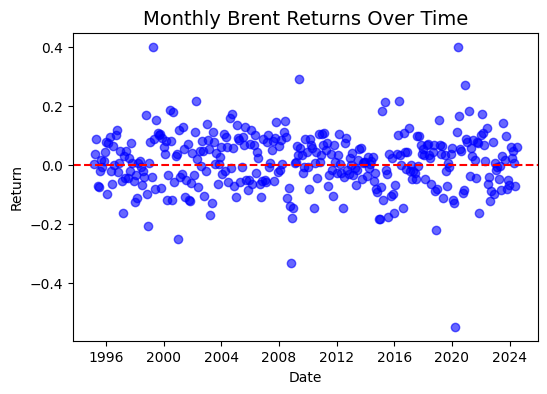

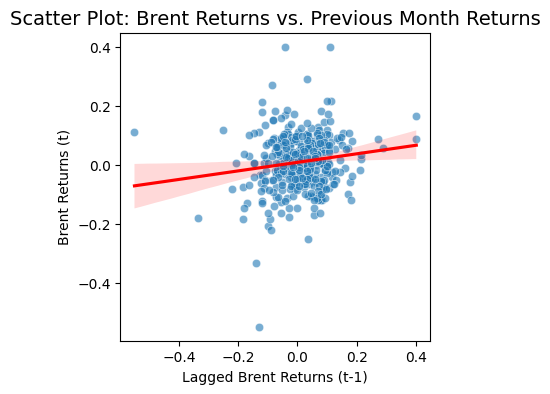

In [135]:
df = ind_m.resample('M').last()

# Brent: TARGET = current monthly Brent return
df['Brent_Ret'] = df['Brent '].pct_change()          # <- target series
df['Lag_Brent_Ret'] = df['Brent_Ret'].shift(1)       # <- can be used as a predictor
df_clean = df.dropna()

print("First one session done")
# =========================================
# PLOT 1: Target Returns Over Time
# =========================================
plt.figure(figsize=(6, 4))
# 'Unknown' 'marker' 'o' creates the scatter dots, linestyle='None' removes connecting lines
plt.plot(df_clean.index, df_clean['Brent_Ret'], marker='o', linestyle='None', alpha=0.6, color='blue')
plt.axhline(y=0, color='r', linestyle='--') # Add a zero line for reference
plt.title('Monthly Brent Returns Over Time', fontsize=14)
plt.ylabel('Return')
plt.xlabel('Date')
plt.show()

# =========================================
# PLOT 2: Target vs. Lagged Target (Checking Autocorrelation)
# =========================================
plt.figure(figsize=(4, 4))
sns.scatterplot(x=df_clean['Lag_Brent_Ret'], y=df_clean['Brent_Ret'], alpha=0.6)

# Regression line to see the trend clearer
sns.regplot(x=df_clean['Lag_Brent_Ret'], y=df_clean['Brent_Ret'], scatter=False, color='red')

plt.title('Scatter Plot: Brent Returns vs. Previous Month Returns', fontsize=14)
plt.xlabel('Lagged Brent Returns (t-1)')
plt.ylabel('Brent Returns (t)')
plt.show()

### Plotting the correlation Matrix
<p> In this section of the code we are plotting the heat map to show case any correlation between regressor variables </p>

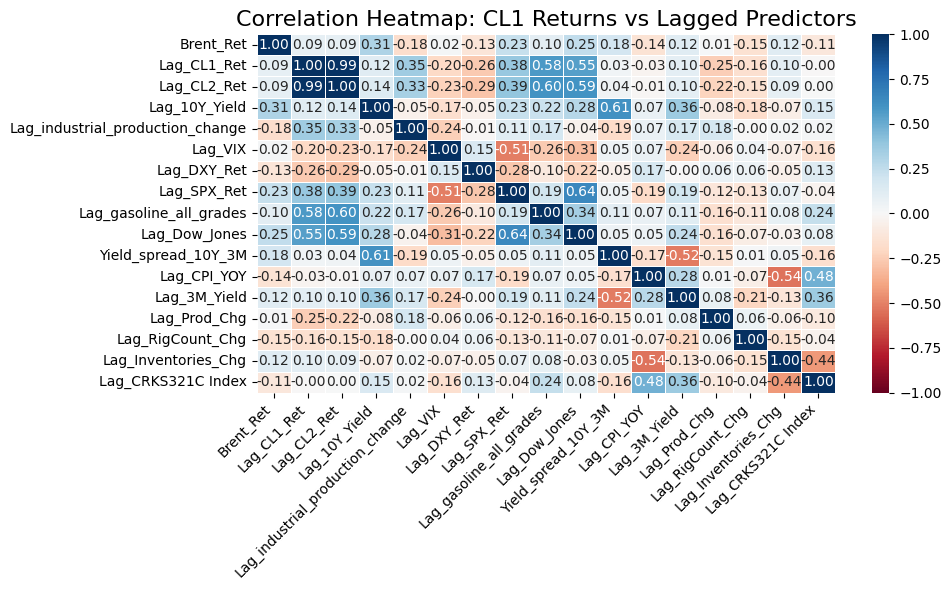

In [136]:
# 2. Engineer Stationary Features
# -------------------------------
# Work on df_m directly
df_m = df_m.copy()

# ---- Target: CL1 monthly NET returns (t) ----
df_m['CL1_Ret'] = df_m['CL1'].pct_change()

# ---- Potential Predictors: all lagged (t-1) ----

# CL2 returns and its lag
df_m['CL2_Ret']      = df_m['CL2'].pct_change()
df_m['Lag_CL2_Ret']  = df_m['CL2_Ret'].shift(1)
df_m['Lag_CL1_Ret']  = df_m['CL1_Ret'].shift(1)
# Brent returns (we use the lag as predictor)
df_m['Brent_Ret']        = df_m['Brent '].pct_change()
df_m['Lag_Brent_Ret']    = df_m['Brent_Ret'].shift(1)

df_m['Lag_CRKS321C Index'] = df_m['CRKS321C Index'].shift(1)
df_m['Lag_Inventories_Chg'] = df_m['Inventories'].shift(1)
df_m['Lag_RigCount_Chg']    = df_m['Rig Count'].shift(1)
df_m['Lag_Baltic_Dry_Index'] = df_m['Baltic Dry Index'].shift(1)
df_m['Lag_Prod_Chg']         = df_m['Daily Production'].diff().shift(1)
df_m['Lag_CPI_YOY']          = df_m['CPI YOY %'].shift(1)
df_m['Lag_3M_Yield']         = df_m['3M Yield'].diff().shift(1)
df_m['Yield_spread_10Y_3M']  = (df_m['10Y Yield'] - df_m['3M Yield']).diff().shift(1)
df_m['Lag_industrial_production_change'] = (
    df_m['IndustrialProduction Index'] / df_m['IndustrialProduction Index'].shift(1)
).shift(1)
df_m['Lag_VIX']                = df_m['VIX'].shift(1)
df_m['Lag_gasoline_all_grades'] = df_m['Gasoline All Grades'].diff().shift(1)
df_m['Lag_Dow_Jones']           = (
    df_m['Dow Jones US Oil&Gas Index'] / df_m['Dow Jones US Oil&Gas Index'].shift(1)
).shift(1)
df_m['Lag_DXY_Ret']            = df_m['DXY returns'].shift(1)
df_m['Lag_SPX_Ret']            = (df_m['SPX'] / df_m['SPX'].shift(1)).shift(1)
df_m['Lag_10Y_Yield']          = df_m['10Y Yield'].diff().shift(1)

# ---- Columns we want in the heatmap ----
# Target (Brent_Ret) + lagged predictors
heatmap_cols = [
    'Brent_Ret',
    'Lag_CL1_Ret',
    'Lag_CL2_Ret',
    'Lag_10Y_Yield',
    'Lag_industrial_production_change',
    'Lag_VIX',
    'Lag_DXY_Ret',
    'Lag_SPX_Ret',
    'Lag_gasoline_all_grades',
    'Lag_Dow_Jones',
    'Yield_spread_10Y_3M',
    'Lag_CPI_YOY',
    'Lag_3M_Yield',
    'Lag_Prod_Chg',
    'Lag_RigCount_Chg',
    'Lag_Inventories_Chg',
    'Lag_CRKS321C Index'
]

df_clean = df_m[heatmap_cols].dropna()

# 3. Calculate Correlation Matrix
# -------------------------------
corr_matrix = df_clean.corr()

# 4. Plot Heatmap
# ---------------
plt.figure(figsize=(10, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='RdBu',
    fmt=".2f",
    vmin=-1, vmax=1,
    linewidths=0.5
)
plt.title('Correlation Heatmap: CL1 Returns vs Lagged Predictors', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### Detecting the outliers
<p> In this section of the code we are plotting and detecting the outliers based on our dates and data </p>

--- Outlier Detection (Threshold: +/- 3 sigma) ---
Upper Bound: 0.3000
Lower Bound: -0.2883

Number of Outliers Found: 2

List of Outliers:
Date
2020-03-31   -0.549881
2020-05-31    0.398101
Name: Brent_ret, dtype: float64


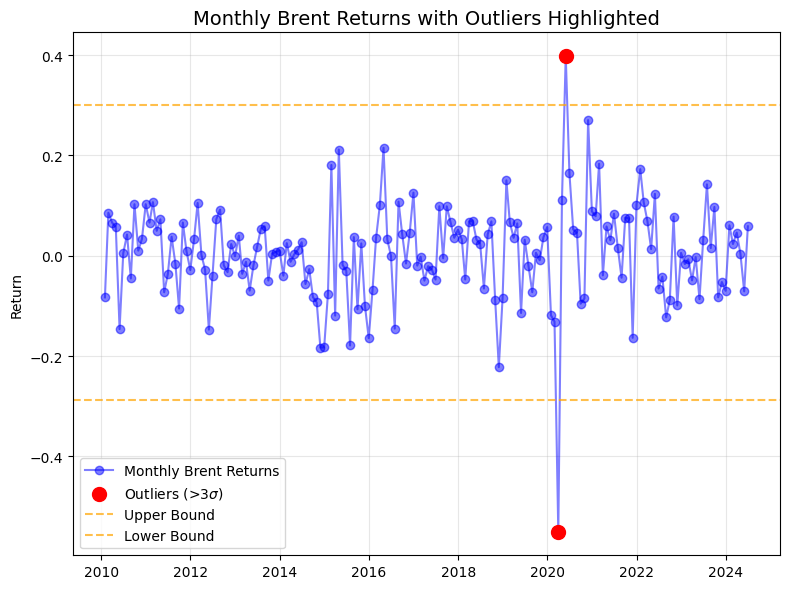

              CL1    CL2  Brent   CRKS321C Index  Baltic Dry Index  \
Date                                                                 
2020-03-31  20.48  24.51   22.74           3.277               626   
2020-05-31  35.49  35.84   35.33           3.340               504   

            Daily Production  Inventories  Rig Count  Commercial Long  \
Date                                                                    
2020-03-31             13000      1104160        728          2226041   
2020-05-31             11200      1180124        301          2034452   

            Commercial Short  Total Open Interest  Brent_ret  Lag_Brent_Ret  
Date                                                                         
2020-03-31           2270327              4496368  -0.549881      -0.131362  
2020-05-31           2063018              4097470   0.398101       0.111258  


In [137]:
# 1. Build monthly Brent returns
df = ind_m.resample('M').last().copy()

df['Brent_ret'] = df['Brent '].pct_change()
df['Lag_Brent_Ret'] = df['Brent_ret'].shift(1)

df = df.loc['2010-01-01':'2024-12-31']

df_clean = df.dropna()
target_series = df_clean['Brent_ret']

mean_ret = target_series.mean()
std_ret = target_series.std()

z_score_threshold = 3

upper_bound = mean_ret + z_score_threshold * std_ret
lower_bound = mean_ret - z_score_threshold * std_ret

outliers = target_series[(target_series > upper_bound) | (target_series < lower_bound)]

print(f"--- Outlier Detection (Threshold: +/- {z_score_threshold} sigma) ---")
print(f"Upper Bound: {upper_bound:.4f}")
print(f"Lower Bound: {lower_bound:.4f}")
print(f"\nNumber of Outliers Found: {len(outliers)}")
print("\nList of Outliers:")
print(outliers.sort_values())

# 3. VISUALISE OUTLIERS
plt.figure(figsize=(8, 6))

plt.plot(target_series.index, target_series,
         marker='o', linestyle='-', alpha=0.5,
         label='Monthly Brent Returns', color='blue')

plt.scatter(outliers.index, outliers,
            color='red', s=100, label='Outliers (>3$\\sigma$)', zorder=5)

plt.axhline(upper_bound, color='orange', linestyle='--', alpha=0.7, label='Upper Bound')
plt.axhline(lower_bound, color='orange', linestyle='--', alpha=0.7, label='Lower Bound')

plt.title('Monthly Brent Returns with Outliers Highlighted', fontsize=14)
plt.ylabel('Return')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 4. Full data for outlier months
df_outliers_analysis = df_clean.loc[outliers.index].copy()
print(df_outliers_analysis)


In [150]:
# =========================
# 2. Load data
# =========================
ind_m = pd.read_excel('Oil Data.xlsx', sheet_name='Industry_M', parse_dates=['Date'], index_col='Date')
macro_m = pd.read_excel('Oil Data.xlsx', sheet_name='Macro_M', parse_dates=['Date'], index_col='Date')
ind_d = pd.read_excel('Oil Data.xlsx', sheet_name='Industry_D', parse_dates=['Date'], index_col='Date')
stockprices_m = pd.read_excel('Oil Data.xlsx', sheet_name='StockPrices_M', parse_dates=['Date'], index_col='Date')

# =========================
# 3. Monthly data prep
# =========================
df_m = pd.concat([ind_m, macro_m, stockprices_m], axis=1).resample('M').last()

# --- TARGET: Brent NET returns (what we forecast) ---
df_m['Brent_Ret'] = df_m['Brent '].pct_change()

df_m['CL1_Ret'] = df_m['CL1'].pct_change()
df_m['CL2_Ret'] = df_m['CL2'].pct_change()

# --- LAGGED predictors (t-1) ---
df_m['Lag_CL2_Ret'] = df_m['CL2_Ret'].shift(1)
df_m['Lag_Brent_Ret'] = df_m['Brent_Ret'].shift(1)
df_m['Lag_CL1_Ret'] = df_m['CL1_Ret'].shift(1)
df_m['Lag_CRKS321C Index'] = df_m['CRKS321C Index'].shift(1)
df_m['Lag_Inventories_Chg'] = df_m['Inventories'].shift(1)
df_m['Lag_RigCount_Chg'] = df_m['Rig Count'].shift(1)
df_m['Lag_Baltic_Dry_Index'] = df_m['Baltic Dry Index'].shift(1)
df_m['Lag_Prod_Chg'] = df_m['Daily Production'].diff().shift(1)
df_m['Lag_CPI_YOY'] = df_m['CPI YOY %'].shift(1)
df_m['Lag_3M_Yield'] = df_m['3M Yield'].diff().shift(1)
df_m['Yield_spread_10Y_3M'] = (df_m['10Y Yield'] - df_m['3M Yield']).diff().shift(1)
df_m['Lag_industrial_production_change'] = (
    df_m['IndustrialProduction Index'] / df_m['IndustrialProduction Index'].shift(1)
).shift(1)
df_m['Lag_VIX'] = df_m['VIX'].shift(1)
df_m['Lag_gasoline_all_grades'] = df_m['Gasoline All Grades'].diff().shift(1)
df_m['Lag_Dow_Jones'] = (
    df_m['Dow Jones US Oil&Gas Index'] / df_m['Dow Jones US Oil&Gas Index'].shift(1)
).shift(1)
df_m['Lag_DXY_Ret'] = df_m['DXY returns'].shift(1)
df_m['Lag_SPX_Ret'] = (df_m['SPX'] / df_m['SPX'].shift(1)).shift(1)
df_m['Lag_10Y_Yield'] = df_m['10Y Yield'].diff().shift(1)

# =============================
# 4. Outlier dummy (COVID)
# =============================
outlier_dates = ['2020-03-31', '2020-05-31']
df_m['Outlier_Dummy'] = 0
for date in outlier_dates:
    if date in df_m.index:
        df_m.loc[date, 'Outlier_Dummy'] = 1

# Clean NA and restrict sample
df_m_c = df_m.dropna()
df_m_clean = df_m_c['2010-01-01':'2024-12-28']

print(f"Data Range Selected: {df_m_clean.index.min().date()} to {df_m_clean.index.max().date()}")
print(f"Number of observations: {len(df_m_clean)}")

print(df_m_clean.head())

Data Range Selected: 2010-01-31 to 2024-06-30
Number of observations: 174
              CL1    CL2  Brent   CRKS321C Index  Baltic Dry Index  \
Date                                                                 
2010-01-31  72.89  73.35   71.46           5.597            2848.0   
2010-02-28  79.66  80.01   77.59           5.652            2738.0   
2010-03-31  83.76  84.18   82.70           7.376            2998.0   
2010-04-30  86.15  88.36   87.44           9.849            3354.0   
2010-05-31  73.97  75.16   74.65           6.848            4078.0   

            Daily Production  Inventories  Rig Count  Commercial Long  \
Date                                                                    
2010-01-31            5403.0    1034898.0     1317.0        1235641.0   
2010-02-28            5510.0    1047340.0     1373.0        1196586.0   
2010-03-31            5489.0    1059993.0     1444.0        1203147.0   
2010-04-30            5522.0    1066543.0     1483.0        1299518.0 

### ADF and Individual Variable Significance Testing
<p> Testing for feature selection, it tests whether the variable is stationary in a time series, and the significance of a variable in an OLS model with Brent returns and the dummy variable. </p>

In [162]:
df_m_clean_adf = df_m_clean.copy()

# ADF and individual significance
def check_stationarity(series):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            # Drop Nas and perform test
            return adfuller(series.dropna(), autolag='AIC')[1]
        except Exception:
            # 1.0 on any failure
            return 1.0 

def test_predictor_model(df, target, base_predictor, new_predictor):
    try:
        features = [base_predictor, new_predictor]
        df_test = df.dropna(subset=[target] + features)
        
        X = sm.add_constant(df_test[features])
        Y = df_test[target]
        
        model = sm.OLS(Y, X).fit(cov_type='HC3')
        return model.pvalues[new_predictor]
    except Exception:
        # Return 1.0 on failure
        return 1.0 

# Variable Selection 

target_variable = 'Brent_Ret'
base_predictor = 'Outlier_Dummy'

df_m_clean_adf['Brent_Ret'] = (df_m_clean_adf['Brent '] / df_m_clean_adf['Brent '].shift(1))
new_candidates_data = {
    'Lag_10Y_Yield': df_m_clean_adf['10Y Yield'].diff().shift(1),
    'Lag_RigCount_Chg_Diff': df_m_clean_adf['Rig Count'].diff().shift(1),
    'Lag_Baltic_Dry_Index_Diff': df_m_clean_adf['Baltic Dry Index'].diff().shift(1),
    'Lag_Prod_Chg': df_m_clean_adf['Daily Production'].diff().shift(1),
    'Lag_CPI_YOY_Diff': df_m_clean_adf['CPI YOY %'].diff().shift(1),
    'Lag_3M_Yield_Diff': df_m_clean_adf['3M Yield'].diff().shift(1),
    'Yield_spread_10Y_3M_Diff': (df_m_clean_adf['10Y Yield'] - df_m_clean_adf['3M Yield']).diff().shift(1),
    'Lag_industrial_production_change': (df_m_clean_adf['IndustrialProduction Index'] / df_m_clean_adf['IndustrialProduction Index'].shift(1)).shift(1),
    'Lag_VIX': df_m_clean_adf['VIX'].shift(1),
    'Lag_gasoline_all_grades_Diff': df_m_clean_adf['Gasoline All Grades'].diff().shift(1),
    'Lag_Dow_Jones_Ret': (df_m_clean_adf['Dow Jones US Oil&Gas Index'] / df_m_clean_adf['Dow Jones US Oil&Gas Index'].shift(1)).shift(1),
    'Lag_SPX_Ret': (df_m_clean_adf['SPX'] / df_m_clean_adf['SPX'].shift(1)).shift(1),
    'Lag_DXY_Ret': df_m_clean_adf['DXY returns'].shift(1),
    'Lag_CRKS321C_Index': df_m_clean_adf['CRKS321C Index'].diff().shift(1)
}

for new_var, series in new_candidates_data.items():
    df_m_clean_adf[new_var] = series

significant_signals = []
failed_adf = []
failed_vif = []
failed_significance = []

candidate_names = list(new_candidates_data.keys())

for name in candidate_names:
    # Stationarity
    adf_pvalue = check_stationarity(df_m_clean_adf[name]) # Use the new dataframe
    if adf_pvalue > 0.05:
        failed_adf.append(name)
        continue
    # OLS
    model_pvalue = test_predictor_model(df_m_clean_adf, target_variable, base_predictor, name) # Use the new dataframe
    if model_pvalue < 0.1:
        significant_signals.append((name, model_pvalue))
    else:
        failed_significance.append(name)

# Output part
if significant_signals:
    print("Significant Predictors (p < 0.1)")
    for var, p in sorted(significant_signals, key=lambda x: x[1]):
        print(f"- {var} (p={p:.4f})")
else:
    print("No significant predictors found.")


if failed_adf:
    print(f"Not Stationary (ADF p > 0.05):\n  {', '.join(failed_adf)}")
if failed_significance:
    print(f"Insignificant (p >= 0.1):\n  {', '.join(failed_significance)}")

print(f"Data Range Selected: {df_m_clean_adf.index.min().date()} to {df_m_clean_adf.index.max().date()}")

Significant Predictors (p < 0.1)
- Lag_10Y_Yield (p=0.0010)
- Lag_CRKS321C_Index (p=0.0098)
- Lag_VIX (p=0.0915)
Insignificant (p >= 0.1):
  Lag_RigCount_Chg_Diff, Lag_Baltic_Dry_Index_Diff, Lag_Prod_Chg, Lag_CPI_YOY_Diff, Lag_3M_Yield_Diff, Yield_spread_10Y_3M_Diff, Lag_industrial_production_change, Lag_gasoline_all_grades_Diff, Lag_Dow_Jones_Ret, Lag_SPX_Ret, Lag_DXY_Ret
Data Range Selected: 2010-01-31 to 2024-06-30


### Plotting our selected variables
<p> In this section we are plotting our selected variables </p>

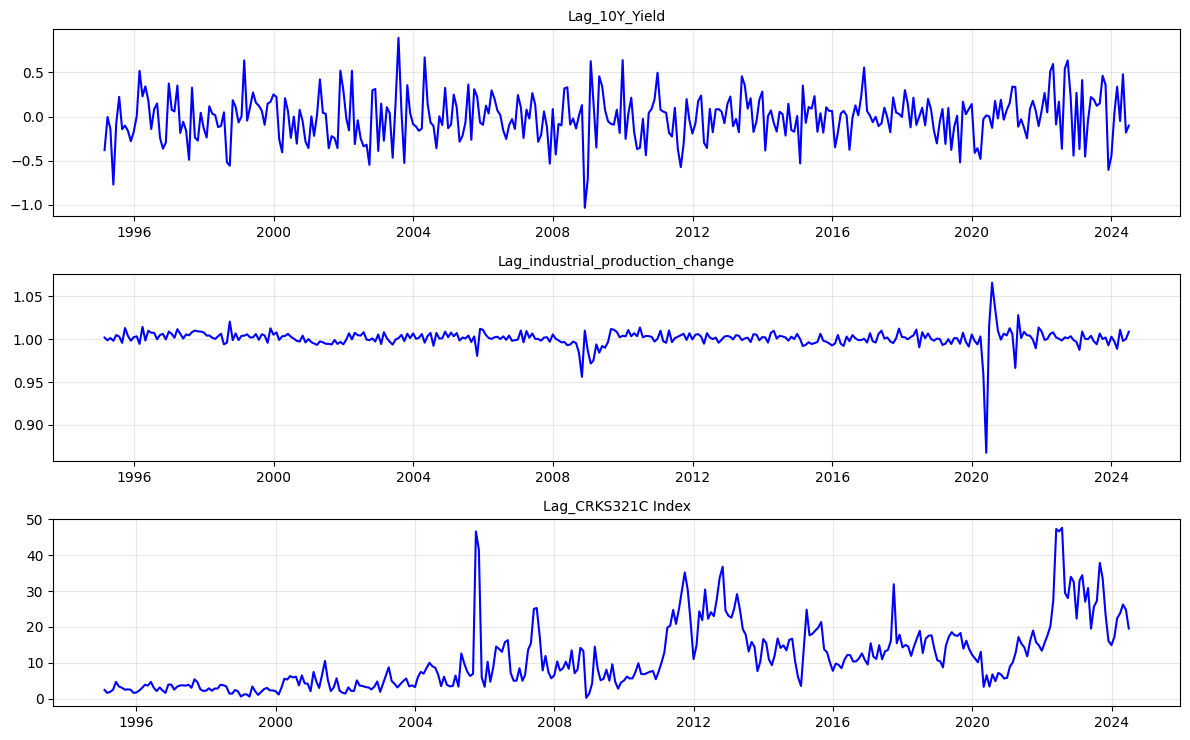

In [140]:
import matplotlib.pyplot as plt

feature_list = ['Lag_10Y_Yield', 'Lag_industrial_production_change','Lag_CRKS321C Index']

df_plot = df_m[feature_list]

# Number of features
n = len(feature_list)

# Set up the subplot grid
plt.figure(figsize=(12, 2.5 * n))

for i, col in enumerate(feature_list, 1):
    plt.subplot(n, 1, i)
    plt.plot(df_plot.index, df_plot[col], label=col, color='blue')
    plt.title(col, fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

plt.show()

### Running the model
<p> In this section we are running the model and generating the needed tests to test our model </p>

ADF Test for Monthly Brent Returns: p-value = 0.0000
Starting rolling forecast from index 139...

Monthly OLS RMSE (returns):      0.085236
Monthly ARIMAX(1,0,0) RMSE:     0.086638
Monthly ARIMAX(1,0,1) RMSE:     0.086764
Naive RMSE:                     0.109910

Out-of-sample R² (vs Naive, returns):
OLS:            0.3986
ARIMAX(1,0,0):  0.3786

--- Diagnostic Tests for ARIMAX(1,0,0) OOS Errors (Brent returns) ---
Ljung-Box (No Autocorr, lag 5): p-val = 0.3959
Durbin-Watson (Autocorr): statistic = 2.4088
→ No serious autocorrelation
Jarque-Bera (Normality): p-val = 0.9235

--- Diagnostic Tests for ARIMAX(1,0,1) OOS Errors (Brent returns) ---
Ljung-Box (No Autocorr, lag 5): p-val = 0.3831
Durbin-Watson (Autocorr): statistic = 2.4285
→ No serious autocorrelation
Jarque-Bera (Normality): p-val = 0.9126

=== FULL SAMPLE OLS SUMMARY (Brent Returns) ===
                            OLS Regression Results                            
Dep. Variable:              Brent_Ret   R-squared:          

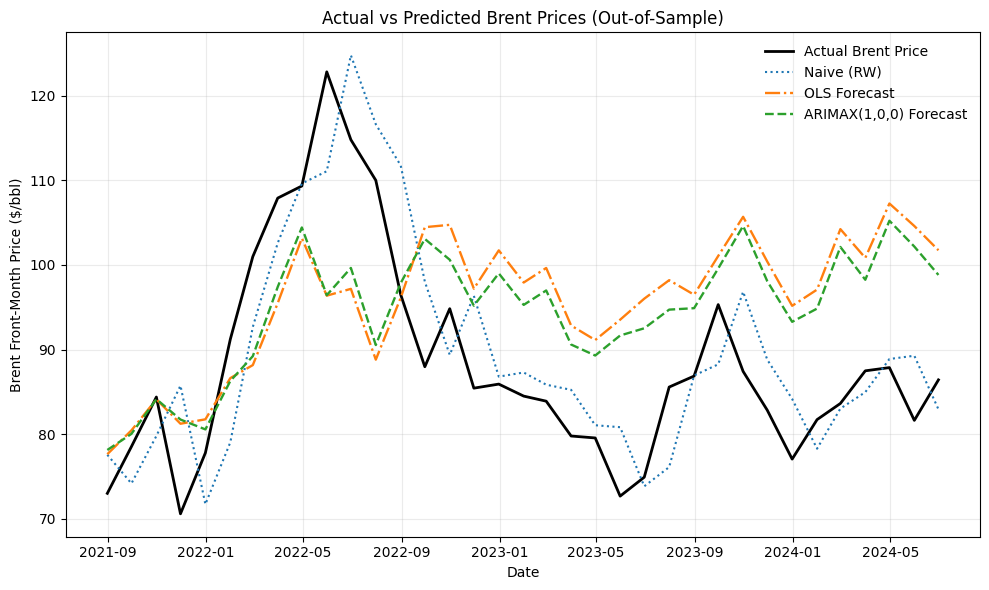

In [141]:
# =========================
# 1. Helper functions
# =========================

def run_diagnostics(residuals, name):
    """Runs Ljung-Box, Durbin-Watson, and Jarque-Bera tests."""
    print(f"\n--- Diagnostic Tests for {name} ---")
    # 1. Ljung-Box for Autocorrelation
    lb_test = acorr_ljungbox(residuals, lags=[5], return_df=True)
    print(f"Ljung-Box (No Autocorr, lag 5): p-val = {lb_test['lb_pvalue'].values[0]:.4f}")

    # 2. Durbin-Watson
    dw_stat = durbin_watson(residuals)
    print(f"Durbin-Watson (Autocorr): statistic = {dw_stat:.4f}")
    if dw_stat < 1.5:
        print("→ Possible positive autocorrelation")
    elif dw_stat > 2.5:
        print("→ Possible negative autocorrelation")
    else:
        print("→ No serious autocorrelation")

    # 3. Jarque-Bera for Normality
    jb_score, jb_pvalue = jarque_bera(residuals)
    print(f"Jarque-Bera (Normality): p-val = {jb_pvalue:.4f}")
    return


def check_stationarity(series, name):
    """Performs Augmented Dickey-Fuller test for stationarity."""
    result = adfuller(series.dropna())
    print(f'ADF Test for {name}: p-value = {result[1]:.4f}')
    return result[1] <= 0.05


def rolling_forecast(df, target_col, feature_cols, train_ratio=0.8):
    """
    Rolling expanding-window forecast for:
      - OLS
      - ARIMAX(1,0,0)
      - ARIMAX(1,0,1)
    """
    n_total = len(df)
    train_size = int(n_total * train_ratio)

    ols_preds, arimax_preds, arimax_preds_1 = [], [], []
    actuals = []

    print(f"Starting rolling forecast from index {train_size}...")

    for t in range(train_size, n_total):
        train = df.iloc[:t]
        test_row = df.iloc[t]

        y_train = train[target_col]
        X_train = sm.add_constant(train[feature_cols])
        X_test = [1.0] + test_row[feature_cols].tolist()

        # 1. Rolling OLS
        model_ols = sm.OLS(y_train, X_train).fit()
        ols_pred = model_ols.predict(X_test)[0]
        ols_preds.append(ols_pred)

        # 2. Rolling ARIMAX(1,0,0) and (1,0,1) on RETURNS (d = 0)
        exog_features = [f for f in feature_cols if f != 'Lag_Brent_Ret']
        exog_train = train[exog_features]
        exog_test = test_row[exog_features].to_frame().T

        model_arimax = ARIMA(y_train, exog=exog_train, order=(1, 0, 0)).fit()
        model_arimax_1 = ARIMA(y_train, exog=exog_train, order=(1, 0, 1)).fit()

        # Forecast one step ahead
        arimax_pred = model_arimax.forecast(steps=1, exog=exog_test).iloc[0]
        arimax_preds.append(arimax_pred)

        arimax_pred_1 = model_arimax_1.forecast(steps=1, exog=exog_test).iloc[0]
        arimax_preds_1.append(arimax_pred_1)

        actuals.append(test_row[target_col])

    return (
        np.array(actuals),
        np.array(ols_preds),
        np.array(arimax_preds),
        np.array(arimax_preds_1),
    )


def returns_to_price(start_price, returns):
    """Convert a series of NET returns into a price path."""
    prices = [float(start_price)]
    for r in returns:
        prices.append(prices[-1] * (1.0 + float(r)))
    return np.array(prices[1:], dtype=float)

# =========================
# 5. Stationarity check
# =========================
check_stationarity(df_m_clean['Brent_Ret'], 'Monthly Brent Returns')

# =========================
# 6. Feature set & rolling forecast (Brent returns)
# =========================
m_features = ['Lag_10Y_Yield', 'Lag_industrial_production_change', 'Lag_CRKS321C Index', 'Outlier_Dummy']

# Forecast BRENT RETURNS
m_actuals, m_ols_preds, m_arimax_preds, m_arimax_preds_1 = rolling_forecast(
    df_m_clean, 'Brent_Ret', m_features
)

# Naive benchmark = last month's Brent return
naive_preds = df_m_clean['Brent_Ret'].shift(1).iloc[-len(m_actuals):].values

# --- Evaluation: MSE, RMSE, OOS R² ---
ols_mse = mean_squared_error(m_actuals, m_ols_preds)
arimax_mse = mean_squared_error(m_actuals, m_arimax_preds)
arimax_mse_1 = mean_squared_error(m_actuals, m_arimax_preds_1)
naive_mse = mean_squared_error(m_actuals, naive_preds)

m_ols_rmse = np.sqrt(ols_mse)
m_arimax_rmse = np.sqrt(arimax_mse)
m_arimax_rmse_1 = np.sqrt(arimax_mse_1)
naive_rmse = np.sqrt(naive_mse)

print(f"\nMonthly OLS RMSE (returns):      {m_ols_rmse:.6f}")
print(f"Monthly ARIMAX(1,0,0) RMSE:     {m_arimax_rmse:.6f}")
print(f"Monthly ARIMAX(1,0,1) RMSE:     {m_arimax_rmse_1:.6f}")
print(f"Naive RMSE:                     {naive_rmse:.6f}")

r2_ols = 1 - (ols_mse / naive_mse)
r2_arimax = 1 - (arimax_mse / naive_mse)
print(f"\nOut-of-sample R² (vs Naive, returns):")
print(f"OLS:            {r2_ols:.4f}")
print(f"ARIMAX(1,0,0):  {r2_arimax:.4f}")

# =========================
# 7. Diagnostics on forecast errors (returns)
# =========================
m_residuals = m_actuals - m_arimax_preds
run_diagnostics(m_residuals, "ARIMAX(1,0,0) OOS Errors (Brent returns)")

m_residuals_1 = m_actuals - m_arimax_preds_1
run_diagnostics(m_residuals_1, "ARIMAX(1,0,1) OOS Errors (Brent returns)")

# =========================
# 8. Full-sample model summaries (returns)
# =========================
print("\n=== FULL SAMPLE OLS SUMMARY (Brent Returns) ===")
X_full = sm.add_constant(df_m_clean[m_features])
Y_full = df_m_clean['Brent_Ret']
final_ols_model = sm.OLS(Y_full, X_full).fit()
print(final_ols_model.summary())

print("\n=== FULL SAMPLE ARIMAX(1,0,0) SUMMARY (Brent Returns) ===")
exog_full = df_m_clean[[f for f in m_features if f != 'Lag_Brent_Ret']]
final_arimax_model = ARIMA(Y_full, exog=exog_full, order=(1, 0, 0)).fit()
print(final_arimax_model.summary())

print("\n=== FULL SAMPLE ARIMAX(1,0,1) SUMMARY (Brent Returns) ===")
final_arimax_model_1 = ARIMA(Y_full, exog=exog_full, order=(1, 0, 1)).fit()
print(final_arimax_model_1.summary())

# =========================
# 9. Convert Brent RETURN forecasts into PRICE forecasts
# =========================
idx_oos = df_m_clean.index[-len(m_actuals):]

# Anchor: last actual Brent price BEFORE OOS window
start_pos = df_m_clean.index.get_loc(idx_oos[0])
P0 = float(df_m_clean['Brent '].iloc[start_pos - 1])

# Actual Brent prices in OOS
price_actual = df_m_clean['Brent '].loc[idx_oos].astype(float).values

# Rebuild price paths from predicted
price_naive = returns_to_price(P0, naive_preds)
price_ols = returns_to_price(P0, m_ols_preds)
price_arimax = returns_to_price(P0, m_arimax_preds)

print("\nBrent price ranges (OOS):")
print("Actual:", price_actual.min(), "to", price_actual.max())
print("ARIMAX:", price_arimax.min(), "to", price_arimax.max())

# Plot: actual vs predicted Brent prices
plt.figure(figsize=(10, 6))
plt.plot(idx_oos, price_actual, label='Actual Brent Price', color='black', linewidth=2)
plt.plot(idx_oos, price_naive, label='Naive (RW)', linestyle=':', linewidth=1.5)
plt.plot(idx_oos, price_ols, label='OLS Forecast', linestyle='-.', linewidth=1.7)
plt.plot(idx_oos, price_arimax, label='ARIMAX(1,0,0) Forecast', linestyle='--', linewidth=1.7)

plt.title('Actual vs Predicted Brent Prices (Out-of-Sample)')
plt.xlabel('Date')
plt.ylabel('Brent Front-Month Price ($/bbl)')
plt.legend(frameon=False)
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


## Running Tests for Stability
<p> In this section we will run the chow test for parameter stability, specifically for the 2020 oil crash </p>

In [142]:

df_chow = df_m_clean.copy() 

break_index = df_chow.index.get_loc("2020-03-31")
m_features = ['Lag_10Y_Yield', 'Lag_industrial_production_change', 'Lag_CRKS321C Index', 'Outlier_Dummy']
y = "Brent_Ret"

# Splitting the data 
df1 = df_chow[:break_index]
df2 = df_chow.iloc[break_index:]

y1 = df1[y]
x1 = sm.add_constant(df1[m_features])

y2 = df2[y]
x2 = sm.add_constant(df2[m_features])

y_all = df_chow[y]
x_all = sm.add_constant(df_chow[m_features])

# Running the OLS models
ols1 = sm.OLS(y1, x1).fit()
ols2 = sm.OLS(y2, x2).fit()
ols_all = sm.OLS(y_all, x_all).fit()


# Getting the residuals
RSS1 = np.sum(ols1.resid**2)
RSS2 = np.sum(ols2.resid**2)
RSS_all = np.sum(ols_all.resid**2)

# Getting the k and n values
k = x_all.shape[1] # Number of parameters (features + const)
n1,n2 = len(df1), len(df2)

# Calculating the F-statistic
num = (RSS_all - (RSS1 + RSS2)) / k
den = (RSS1 + RSS2) / (n1 + n2 - 2 * k)

F = num / den
#Getting the F(T2, T1-K)
df_num = k
df_den = n1 + n2 - 2 * k
f_val = 1 - stats.f.cdf(F, df_num, df_den)

print(n1)
print(n2)
print(f_val)
print(F)

122
52
0.021418237638381465
2.7273813345446865


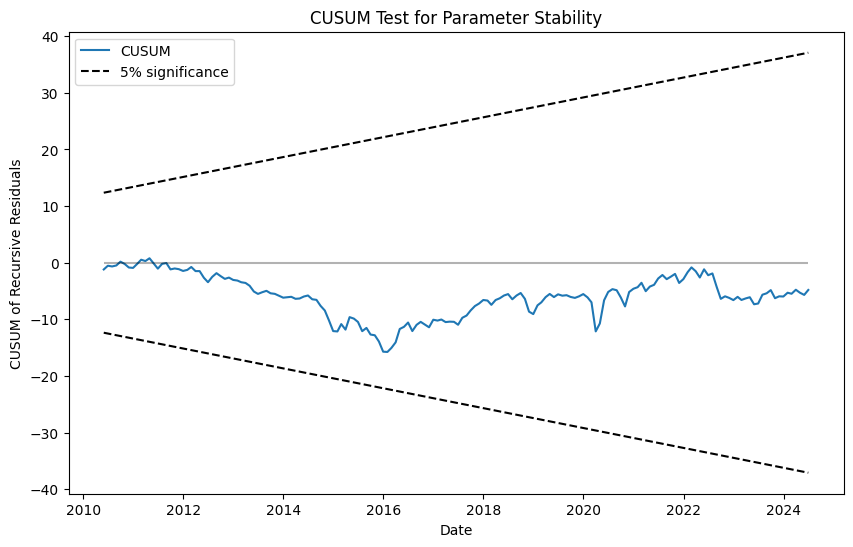

Data Range Selected: 2010-01-31 to 2024-06-30


In [164]:

df_cusum = df_m_clean.copy()

# Define model variables
target_variable = 'Brent_Ret'
m_features_final = [
    'Lag_10Y_Yield',
    'Lag_CRKS321C Index',
    'Lag_VIX'
]

# Drop NaNs
df_cusum_final = df_cusum.dropna(subset=[target_variable] + m_features_final)

Y_full = df_cusum_final[target_variable]
X_final = sm.add_constant(df_cusum_final[m_features_final])

# Run the Recursive OLS and plot CUSUM
res = sm.RecursiveLS(Y_full, X_final)
res_fit = res.fit()

# Create the plot
fig = res_fit.plot_cusum(figsize=(10, 6))
    
plt.title(f'CUSUM Test for Parameter Stability')
plt.xlabel('Date')
plt.ylabel('CUSUM of Recursive Residuals')
    
plt.show(fig)

print(f"Data Range Selected: {df_cusum.index.min().date()} to {df_cusum.index.max().date()}")

### Fixing Heteroskedacticity
<p> In this section we are running and then detecting heteroskedaciticity and fixing it using the robust method </p>

In [146]:
# Breusch-Pagan
bp_test = het_breuschpagan(final_ols_model.resid, final_ols_model.model.exog)

bp_pvalue = bp_test[1]
print("Breusch–Pagan p-value:", bp_pvalue)

Breusch–Pagan p-value: 3.1588090286936714e-13


In [147]:
from statsmodels.stats.diagnostic import het_arch
arch_test = het_arch(final_arimax_model.resid)
print(arch_test[1])   # p-value


0.0035700236456486494


In [148]:
#Detecting and fixing heteroskedacticity
ols_robust = final_ols_model.get_robustcov_results(cov_type='HC3')
print(ols_robust.summary())


                            OLS Regression Results                            
Dep. Variable:              Brent_Ret   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     5.903
Date:                Tue, 18 Nov 2025   Prob (F-statistic):           0.000180
Time:                        01:13:30   Log-Likelihood:                 177.27
No. Observations:                 174   AIC:                            -344.5
Df Residuals:                     169   BIC:                            -328.7
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

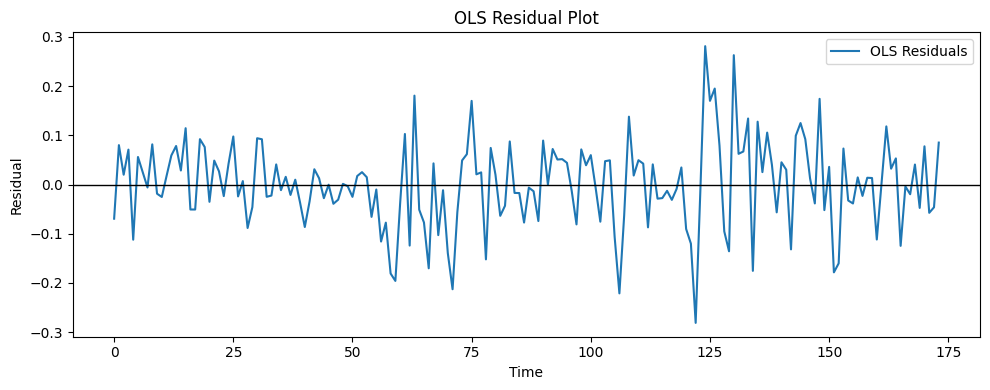

In [102]:
#Plotting the residuals
import matplotlib.pyplot as plt

# Assuming: ols_model = sm.OLS(...).fit()
ols_resid = ols_robust.resid

plt.figure(figsize=(10,4))
plt.plot(ols_resid, label="OLS Residuals")
plt.axhline(0, color='black', linewidth=1)
plt.title("OLS Residual Plot")
plt.xlabel("Time")
plt.ylabel("Residual")
plt.legend()
plt.tight_layout()
plt.show()

In [103]:
# --- Run Granger Causality Test ---
# --- NEW TARGET: Brent_Ret ---
#
# H0 (Null): The predictor does NOT Granger-cause 'Brent_Ret'

try:
    target_variable = 'Brent_Ret'

    # We used the NON-LAGGED, stationary versions. The test creates its own lags.
    predictors_to_test = {
        '10Y_Yield_Diff': "Lag_10Y_Yield",
        'Crack_Spread_Diff': "Lag_Crack_Spread_Diff",
        'VIX': "Lag_VIX", # VIX is already stationary (p=0.0000)
        'Outlier_Dummy': "Outlier_Dummy" # Test the dummy as well
    }

    # --- Re-create the non-lagged source variables ---
    df_m_clean['10Y_Yield_Diff'] = df_m_clean['10Y Yield'].diff()
    df_m_clean['Crack_Spread_Diff'] = df_m_clean['CRKS321C Index'].diff()
    df_m_clean['Brent_Ret'] = (df_m_clean['Brent '] / df_m_clean['Brent '].shift(1))
    # VIX and Outlier_Dummy are used directly

    print(f"--- Granger Causality Test Results (Target: {target_variable}) ---")
    print("H0: The predictor does NOT Granger-cause the target.\n")

    max_lags = 3 # Test for 3 lags

    # --- Loop and test each predictor ---
    for source_var, model_var in predictors_to_test.items():
        print(f"Testing predictor: '{model_var}' (source: '{source_var}')...")

        test_df = df_m_clean[[target_variable, source_var]].dropna()

        if test_df.empty:
            print(f"  > FAILED: DataFrame is empty for {source_var}. Skipping.\n")
            continue

        test_results = grangercausalitytests(test_df, maxlag=[max_lags], verbose=False)

        # Get p-value for the F-test at the max lag
        p_value = test_results[max_lags][0]['ssr_ftest'][1]

        print(f"  > p-value at {max_lags} lags: {p_value:.4f}")
        if p_value < 0.05:
            print(f"  > Result: PASS. '{model_var}' is a useful predictor.\n")
        else:
            print(f"  > Result: FAIL. '{model_var}' is not a useful predictor (p > 0.05).\n")

    print("--- Interpretation ---")
    print("Low p-values (< 0.05) provide formal justification for including")
    print("these predictors in your model, as required by the brief.")

except NameError:
    print("Error: Please make sure 'df_m_clean' is defined and populated from your main notebook script.")
except Exception as e:
    print(f"An error occurred: {e}")

--- Granger Causality Test Results (Target: Brent_Ret) ---
H0: The predictor does NOT Granger-cause the target.

Testing predictor: 'Lag_10Y_Yield' (source: '10Y_Yield_Diff')...
  > p-value at 3 lags: 0.0002
  > Result: PASS. 'Lag_10Y_Yield' is a useful predictor.

Testing predictor: 'Lag_Crack_Spread_Diff' (source: 'Crack_Spread_Diff')...
  > p-value at 3 lags: 0.3416
  > Result: FAIL. 'Lag_Crack_Spread_Diff' is not a useful predictor (p > 0.05).

Testing predictor: 'Lag_VIX' (source: 'VIX')...
  > p-value at 3 lags: 0.0369
  > Result: PASS. 'Lag_VIX' is a useful predictor.

Testing predictor: 'Outlier_Dummy' (source: 'Outlier_Dummy')...
  > p-value at 3 lags: 0.0127
  > Result: PASS. 'Outlier_Dummy' is a useful predictor.

--- Interpretation ---
Low p-values (< 0.05) provide formal justification for including
these predictors in your model, as required by the brief.
